# МС КРЕД

Мульти-скале конволюшн реккурент энкодер декодер

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

### Seed fixation

In [2]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [91]:
df = pd.read_csv("./data/valve1/0.csv", sep=";", parse_dates=True, index_col="datetime")
first_anomaly_idx = df.index.get_loc(df[df["anomaly"] == 1].index[0])
anomaly = df.anomaly
df = df.drop(["anomaly", "changepoint"], axis=1)
df.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.33020,0.054711,79.3366,26.0199,233.062,32.0
2020-03-09 10:14:34,0.026170,0.040453,1.35399,0.382638,79.5158,26.0258,236.040,32.0
2020-03-09 10:14:35,0.026199,0.039419,1.54006,0.710565,79.3756,26.0265,251.380,32.0
2020-03-09 10:14:36,0.026027,0.039641,1.33458,0.382638,79.6097,26.0393,234.392,32.0
2020-03-09 10:14:37,0.026290,0.040273,1.07851,-0.273216,79.6109,26.0420,225.342,32.0


### Make model

In [4]:
def create_dataset(df, win_size, gap_time, step_max):

    data = np.array(df, dtype=np.float64)
    sensor_n = data.shape[1]
    data_all = []
    scale_n = len(win_size)
    # min-max normalization
    data = MinMaxScaler().fit_transform(data).T

    for win in win_size:
        matrix_all = []
        print(f"generating signature with window {win} ...")
        for t in range(win_size[-1], len(df), gap_time):
            matrix_t = np.zeros((sensor_n, sensor_n))
            for i in range(sensor_n):
                for j in range(i, sensor_n):
                    matrix_t[i][j] = np.inner(data[i, t - win:t], data[j, t - win:t])/(win) # rescale by win
                    matrix_t[j][i] = matrix_t[i][j]
            matrix_all.append(matrix_t)
        data_all.append(matrix_all)

    data_all = np.transpose(data_all, (1,2,3,0))

    print (f"create dataset ...")

    dataset = data_all[:step_max]
    for i in range(step_max+1, len(data_all)+1):
        dataset = np.append(dataset, data_all[i-step_max:i], axis=0)

    return dataset.reshape([-1, step_max, sensor_n, sensor_n, scale_n])

In [123]:
win_sizes = [30, 40, 50]
gap_time = 1
h = 5

train_size = first_anomaly_idx

dataset = create_dataset(df[:train_size], win_sizes, gap_time, h)

generating signature with window 30 ...
generating signature with window 40 ...
generating signature with window 50 ...
create dataset ...


In [124]:
import tensorflow as tf
from tensorflow import keras

In [125]:
from keras.models import Model
from keras.layers import Input, TimeDistributed, Conv2D, ConvLSTM2D, Conv2DTranspose, RepeatVector

In [126]:
class MSCRED:
    def __init__(self):
        pass
    
    def fit(self, train_dataset, batch_size=32, epochs=2):
        
        t, h, n, _, s = train_dataset.shape
        input_layer = Input(shape = (h, n, n, s))
        
        encoder_conv1 = TimeDistributed(Conv2D(filters = 32, kernel_size = 3, 
                               strides = 1, padding = "same",
                               activation="selu", kernel_initializer = "glorot_uniform"))(input_layer)
        
        encoder_conv2 = TimeDistributed(Conv2D(filters = 64, kernel_size = 3, 
                               strides = 2, padding = "same",
                               activation="selu", kernel_initializer = "glorot_uniform"))(encoder_conv1)
        
        encoder_conv3 = TimeDistributed(Conv2D(filters = 128, kernel_size = 2, 
                               strides = 2, padding = "same",
                               activation="selu", kernel_initializer = "glorot_uniform"))(encoder_conv2)
        
        encoder_conv4 = TimeDistributed(Conv2D(filters = 256, kernel_size = 2, 
                               strides = 2, padding = "same",
                               activation="selu", kernel_initializer = "glorot_uniform"))(encoder_conv3)
        
        
        lstm_conv1 =  ConvLSTM2D(filters=32, kernel_size = 2, 
                                 padding = "same", return_sequences = True)(encoder_conv1)
        
        lstm_conv2 =  ConvLSTM2D(filters=64, kernel_size = 2, 
                                 padding = "same", return_sequences = True)(encoder_conv2)
        
        lstm_conv3 =  ConvLSTM2D(filters=128, kernel_size = 2, 
                                 padding = "same", return_sequences = True)(encoder_conv3)
        
        lstm_conv4 =  ConvLSTM2D(filters=256, kernel_size = 2, 
                                 padding = "same", return_sequences = True)(encoder_conv4)
        
        decoder_conv4 = TimeDistributed(Conv2DTranspose(filters=128, kernel_size = 2, strides = 2,
                                       kernel_initializer = "glorot_uniform", padding = "same",
                                       activation = "selu"))(lstm_conv4)
        decoder4_out = tf.concat([decoder_conv4, lstm_conv3], axis = 4)
        
        decoder_conv3 = TimeDistributed(Conv2DTranspose(filters=64, kernel_size = 2, strides = 2,
                                       kernel_initializer = "glorot_uniform", padding = "same",
                                       activation = "selu"))(decoder4_out)
        decoder3_out = tf.concat([decoder_conv3, lstm_conv2], axis = 4)
        
        decoder_conv2 = TimeDistributed(Conv2DTranspose(filters=32, kernel_size = 3, strides = 2,
                                       kernel_initializer = "glorot_uniform", padding = "same",
                                       activation = "selu"))(decoder3_out)
        decoder2_out = tf.concat([decoder_conv2, lstm_conv1], axis = 4)
        
        decoder_conv1 = TimeDistributed(Conv2DTranspose(filters=s, kernel_size = 3, strides = 1,
                                       kernel_initializer = "glorot_uniform", padding = "same",
                                       activation = "selu"))(decoder2_out)

        def loss_function(y_true, y_pred):
            return tf.reduce_mean(tf.square(y_true - y_pred))
        
        self.model = Model(input_layer, decoder_conv1)
        self.model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
                           loss=loss_function)
        
        self.model.fit(train_dataset, train_dataset, epochs=epochs, batch_size=batch_size, verbose=True)
        
        return self
    
    def predict(self, test_dataset):
        return self.model.predict(test_dataset)

In [127]:
model = MSCRED().fit(dataset, epochs=1, batch_size=10)

52/52 [==============================] - 31s 375ms/step - loss: 0.0379


In [128]:
test_dataset = create_dataset(df, win_sizes, gap_time, h)
predictions = model.predict(test_dataset)

generating signature with window 30 ...
generating signature with window 40 ...
generating signature with window 50 ...
create dataset ...


In [129]:
residuals = test_dataset - predictions
residuals.shape

(1093, 5, 8, 8, 3)

### Result interpretation

In [130]:
resid_mat = residuals[:, -1]
resid_mat.shape

(1093, 8, 8, 3)

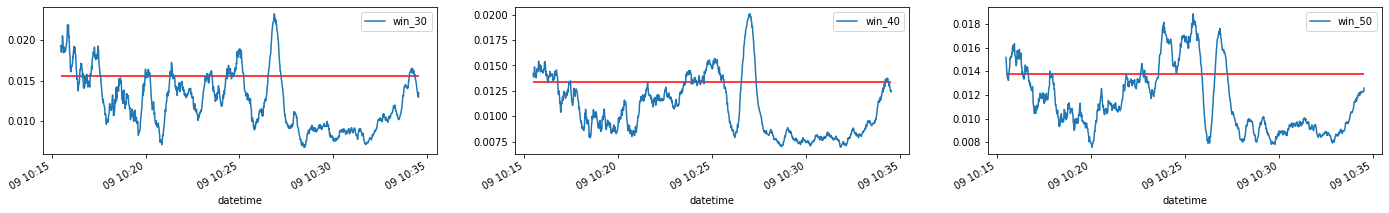

In [190]:
mse = np.mean(np.square(resid_mat), axis=(1,2))
t = df.index[win_sizes[-1]::gap_time][h-1:]
mse_df = pd.DataFrame(mse, 
                      index=t,
                      columns=[f'win_{i}' for i in win_sizes])
UCL = mse_df[:train_size].quantile(0.7)

fig, axes = plt.subplots(1, len(win_sizes), figsize=(24,3))
for i, col in enumerate(mse_df.columns):
    ax = axes.flatten()[int(i)]
    ax.hlines(UCL[col], t[0], t[-1], 'r')
    mse_df[col].plot(ax=ax)
    ax.legend()

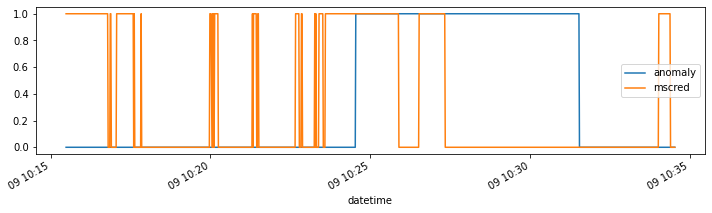

In [193]:
prediction = pd.DataFrame((mse_df>UCL),
                          t).fillna(0).apply(lambda x: x.sum() >= len(x) * 0.2, axis=1).astype(int)
anomaly[win_sizes[-1] + h - 1:].plot(figsize=(12,3))
plt.plot(t, prediction, label = 'mscred')
plt.legend()
plt.show()

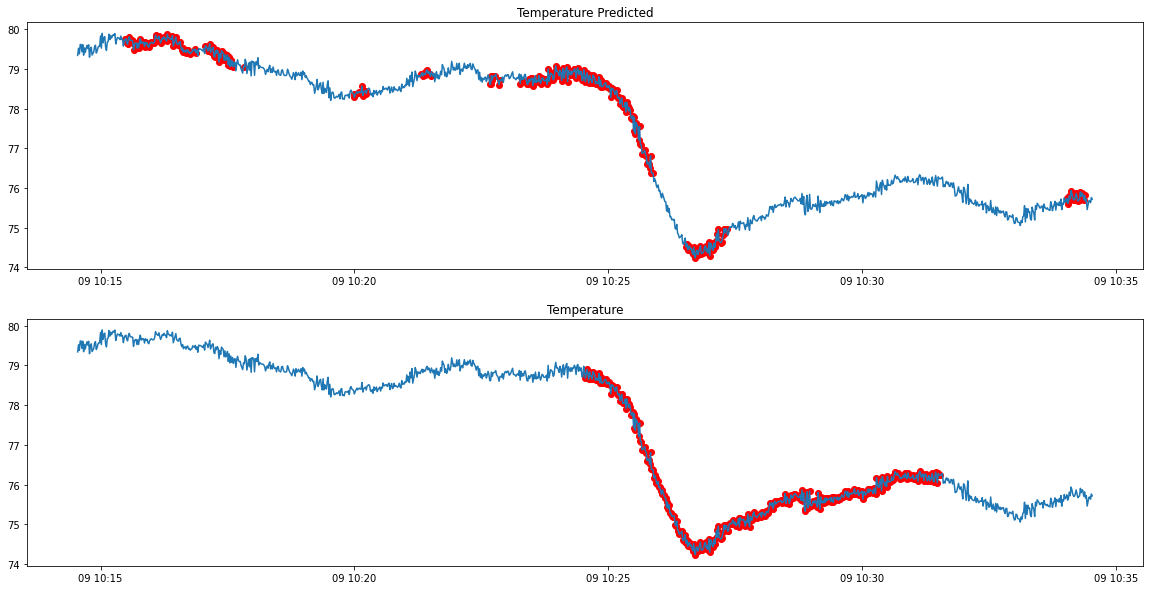

In [194]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(prediction)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(anomaly)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

In [195]:
from utils.metrics import f1_score, far, mar

In [196]:
true_outlier = anomaly[win_sizes[-1] + h - 1:]
print(f"F1 = {f1_score(prediction, true_outlier)}\n",
      f"FAR = {far(prediction, true_outlier)}\n", 
      f"MAR = {mar(prediction, true_outlier)}", sep="")

F1 = 0.3315508021390374
FAR = 0.37131367292225204
MAR = 0.6426512968299711
